# Semi-automated adaptive forecasting using synthetic "black swan" events
---

The following describes a methodology to create a forecast model that is capable of adapting to unpredictable market changes, i.e., black swans. The approach is similar to regime switching, in which model parameters are dependent on the observed regime or state of the system. Here, we apply this concept to a non-parametric model where system state is an input variable.

With the exception of the COVID-induced downturn in March 2020, the 3 years of record used for model development were devoid of black swan events. Therefore, model training necessitated generating synthetic black swans to cover a range of potential system states. These "fake" black swans were created by perturbing the real target signal along exponential waveforms to mimic both "depletion" and "surge" profiles, which correspond to recession- and "hoarding"-like behaviors. To ensure model robustness, perturbations were randomly distributed in space (store locations) and time, and the amplitude and scale of perturbations were randomly selected from normal distributions.

Synthetic examples were used to establish triggering criteria to signify a change in system state. Detected state changes were then archived by creating time-dependent binary flag variables and attaching them to the synthetic samples. Model training was conducted on a rougly 1:1 distribution of real and synthetic samples. Performance was evaluated by first applying the triggering criteria to both out-of-sample synthetic and out-of-time real samples (including the COVID effect), then feeding the resulting state change information into the trained model to generate forecasts for the test periods.

The proposed implementation of this approach in a production forecast pipeline follows a semi-automated scheme as follows:
> 1. Real and forecasted volume are automatically monitored subject to the triggering conditions defined below
> 2. If the triggering condition is met, generate a report alerting management/operations of a potential anomaly
> 3. Upon verification by the necessary parties that the detected anomaly coincides with an anticipated period of sustained lower or higher than normal volume, "switch" the model to the appropriate regime by passing non-zero state flags  
> 4. Continue to monitor model performance and market trends in an automated fashion to alert for potential recovery and stabilization (as described below), then adjust the model state flags accordingly


## 1. Train the base model
---

Black swans will be triggered based on the divergence between predicted and actual volume. Before establishing the trigger criteria, a baseline model was trained on normal volume profiles. This model was then used to make predictions on the synthetic black swan samples, thereby allowing quantification of model divergence.

Load real invoice sample set - processed invoice data from 2017-01-01 through 2020-04-01 for roughly 100 randomly selected stores.

In [1]:
import pandas as pd
real_invoices_sample = pd.read_csv('real_invoice_processed_features.csv').dropna()
real_invoices_sample = real_invoices_sample.loc[real_invoices_sample['is_sunday'] == 0].drop('is_sunday', axis=1)
real_invoices_sample['date'] = pd.to_datetime(real_invoices_sample['date'])
real_invoices_sample.head()

,prev_week_invoice,prev_week_phone,holiday_cwt,promotion,promotion_cwt,prev_week_precip,prev_week_snowfall,party,avg_daily_temp,avg_yearly_pcp,...,is_thursday,is_tuesday,is_wednesday,precip_moving_mean7,precip_moving_mean35,snow_moving_mean7,snow_moving_mean35,y_data,date,store_id
14,92.0,56.0,0.015270,0,-0.085849,0.0314,0.0,0.0,288.654135,1297.97597,...,0,0,0,0.314886,0.215548,0.0,0.0,64.0,2017-01-30,TNN 03
15,92.0,56.0,0.007459,0,-0.086584,0.0314,0.0,0.0,288.654135,1297.97597,...,0,1,0,0.314886,0.215548,0.0,0.0,74.0,2017-01-31,TNN 03
16,92.0,56.0,0.003382,0,-0.086193,0.0314,0.0,0.0,288.654135,1297.97597,...,0,0,1,0.314886,0.215548,0.0,0.0,65.0,2017-02-01,TNN 03
17,92.0,56.0,0.001426,0,-0.084276,0.0314,0.0,0.0,288.654135,1297.97597,...,1,0,0,0.314886,0.215548,0.0,0.0,76.0,2017-02-02,TNN 03
18,92.0,56.0,0.000560,0,-0.080574,0.0314,0.0,0.0,288.654135,1297.97597,...,0,0,0,0.314886,0.215548,0.0,0.0,72.0,2017-02-03,TNN 03


Split data into "in-time" and "out-of-time" samples for training and validation. Separate the target value ("y_data") from the predictors.

In [2]:
time_split = '2019-09-01'
real_invoices_dict = {
    'X_train': real_invoices_sample.loc[real_invoices_sample['date'] < time_split].drop(['y_data', 'date', 'store_id'], axis=1),
    'y_train': real_invoices_sample.loc[real_invoices_sample['date'] < time_split][['y_data', 'date', 'store_id']],
    'X_test' : real_invoices_sample.loc[real_invoices_sample['date'] >= time_split].drop(['y_data', 'date', 'store_id'], axis=1),
    'y_test' : real_invoices_sample.loc[real_invoices_sample['date'] >= time_split][['y_data', 'date', 'store_id']]
}

Train baseline model on in-time sample.

In [3]:
from sklearn.ensemble import GradientBoostingRegressor
base_model = GradientBoostingRegressor(random_state=0, verbose=True).fit(
    real_invoices_dict['X_train'], 
    real_invoices_dict['y_train']['y_data']
)

      Iter       Train Loss   Remaining Time 
         1         711.9530           58.76s
         2         610.0209            1.06m
         3         526.7657           59.87s
         4         458.5174           57.86s
         5         402.8631           55.21s
         6         357.2485           53.69s
         7         319.8231           52.49s
         8         289.0029           52.27s
         9         263.7244           50.96s
        10         242.7824           49.84s
        20         154.5230           41.05s
        30         135.5108           38.14s
        40         127.4842           34.37s
        50         122.5842           28.53s
        60         119.1821           21.94s
        70         116.7651           15.86s
        80         114.8179           10.22s
        90         113.2999            4.95s
       100         112.0357            0.00s


Make forecasts for the out-of-time period and join the results with actual values.

In [4]:
real_oot_predictions = base_model.predict(real_invoices_dict['X_test'])
real_forecast_results = real_invoices_dict['y_test'].copy()
real_forecast_results['predicted'] = real_oot_predictions

Plot out-of-time forecasts for a single store. Note that the base model is unable to self-correct during the observed period following the sudden downturn that occurred in late March, 2020.

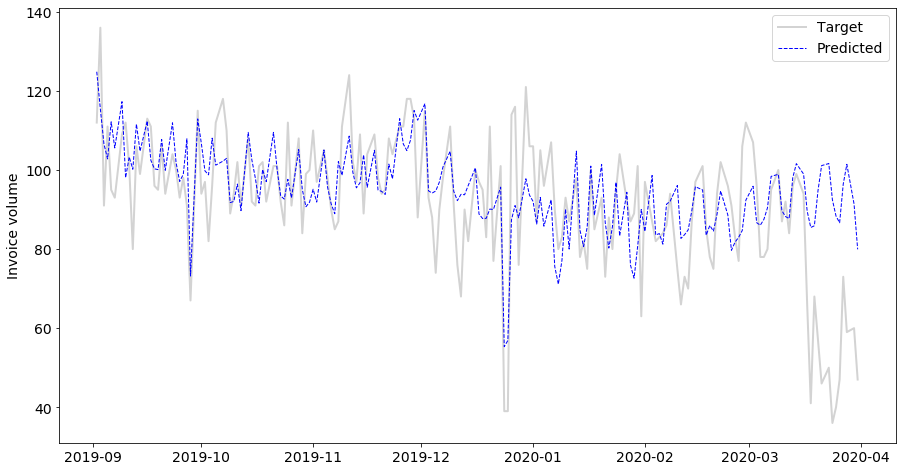

In [5]:
import matplotlib.pyplot as plt

def make_forecast_plot(predictions_df):
    plt.rcParams['font.size'] = 14
    plt.figure(figsize=(15, 8))
    plt.plot(predictions_df['date'], predictions_df['y_data'], color='lightgrey', linewidth=2, label='Target')
    plt.plot(predictions_df['date'], predictions_df['predicted'], color='blue', linewidth=1, linestyle='--', label='Predicted')
    plt.ylabel('Invoice volume')
    plt.legend()

store = 'TNN 03'
store_results = real_forecast_results.loc[real_forecast_results['store_id']==store]
make_forecast_plot(store_results)

## 2. Establish black swan triggering mechanism based on model residuals
---

Load synthetic examples - artificial depletion and surge profiles created by perturbation of actual invoice volume for 100 stores exclusive of those used above. All synthetic examples are trimmed to exclude the COVID period for training. 5 stores are reserved from each set for out-of-sample testing.

In [6]:
import random
random.seed(0)

time_split = '2019-09-01'

# Synthetic depletion
syn_invoices_depletion = pd.read_csv('synthetic_invoice_depletion_processed_features.csv').dropna()
syn_invoices_depletion = syn_invoices_depletion.loc[syn_invoices_depletion['is_sunday'] == 0].drop('is_sunday', axis=1)
syn_invoices_depletion['date'] = pd.to_datetime(syn_invoices_depletion['date'])
syn_invoices_depletion = syn_invoices_depletion.loc[syn_invoices_depletion['date'] < time_split]
out_samp_stores = random.sample(list(pd.unique(syn_invoices_depletion['store_id'])), 5)

syn_invoices_depletion_dict = {
    'X_train': syn_invoices_depletion.loc[~syn_invoices_depletion['store_id'].isin(out_samp_stores)].drop(['y_data', 'date', 'store_id'], axis=1),
    'y_train': syn_invoices_depletion.loc[~syn_invoices_depletion['store_id'].isin(out_samp_stores)][['y_data', 'date', 'store_id']],
    'X_test' : syn_invoices_depletion.loc[syn_invoices_depletion['store_id'].isin(out_samp_stores)].drop(['y_data', 'date', 'store_id'], axis=1),
    'y_test' : syn_invoices_depletion.loc[syn_invoices_depletion['store_id'].isin(out_samp_stores)][['y_data', 'date', 'store_id']]
}

# Synthetic surge
syn_invoices_surge = pd.read_csv('synthetic_invoice_surge_processed_features.csv').dropna()
syn_invoices_surge = syn_invoices_surge.loc[syn_invoices_surge['is_sunday'] == 0].drop('is_sunday', axis=1)
syn_invoices_surge['date'] = pd.to_datetime(syn_invoices_surge['date'])
syn_invoices_surge = syn_invoices_surge.loc[syn_invoices_surge['date'] < time_split]

syn_invoices_surge_dict = {
    'X_train': syn_invoices_surge.loc[~syn_invoices_surge['store_id'].isin(out_samp_stores)].drop(['y_data', 'date', 'store_id'], axis=1),
    'y_train': syn_invoices_surge.loc[~syn_invoices_surge['store_id'].isin(out_samp_stores)][['y_data', 'date', 'store_id']],
    'X_test' : syn_invoices_surge.loc[syn_invoices_surge['store_id'].isin(out_samp_stores)].drop(['y_data', 'date', 'store_id'], axis=1),
    'y_test' : syn_invoices_surge.loc[syn_invoices_surge['store_id'].isin(out_samp_stores)][['y_data', 'date', 'store_id']]
}

Use the base model to make forecasts for the synthetic examples.

In [7]:
# Depletion
syn_depletion_predictions = base_model.predict(syn_invoices_depletion_dict['X_train'])
depletion_results = syn_invoices_depletion_dict['y_train'].copy()
depletion_results['predicted'] = syn_depletion_predictions

# Surge
syn_surge_predictions = base_model.predict(syn_invoices_surge_dict['X_train'])
surge_results = syn_invoices_surge_dict['y_train'].copy()
surge_results['predicted'] = syn_surge_predictions

Plot predicted values for a single store to illustrate base model divergence. 

The behavior of the base model on a synthetic depletion event is characterized by overprediction into the dip followed by underprediction after reversal of the trend. Conversely, a volume surge results in underprediction into the hump followed by trailing overprediction.

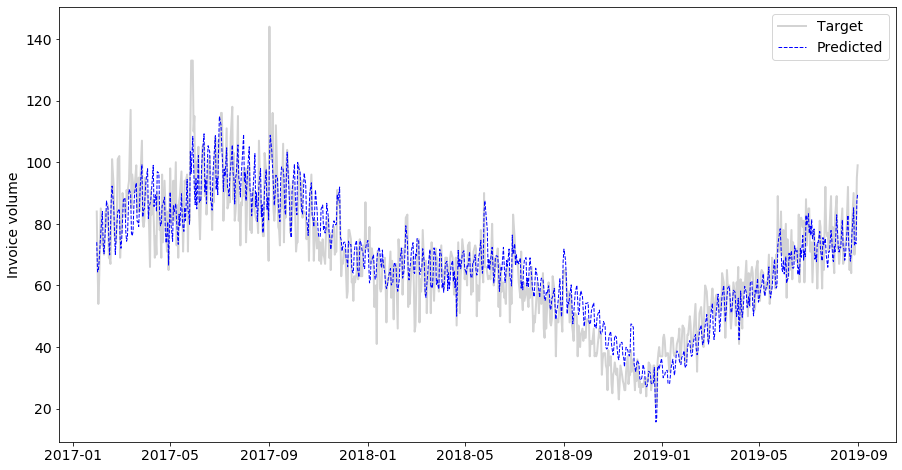

In [8]:
# Depletion
store = 'AZP 48'

store_results_depletion = depletion_results.loc[depletion_results['store_id']==store]
make_forecast_plot(store_results_depletion)

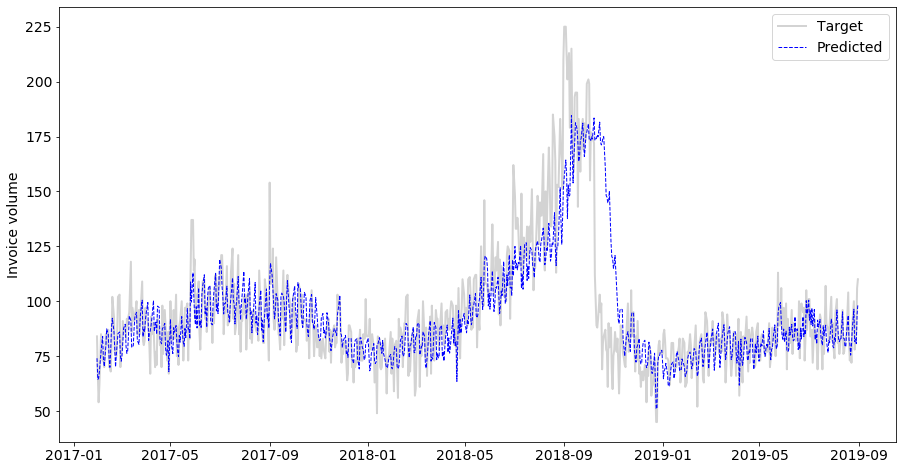

In [9]:
# Surge
store = 'AZP 48'

store_results_surge = surge_results.loc[surge_results['store_id']==store]
make_forecast_plot(store_results_surge)

The following functions are used to create binary flags that characterize black swans. First, define the 3 control points needed to create new flag variables for the black swan enhanced model. The control points are as follows:
> 1. **Trigger** - point at which the moving average of relative residual between prediction and actual exceeds specified threshold value 
> 2. **Recovery** - reversal point of a down trend or up trend; coincides with the maximum observed divergence between predicted and actual values
> 3. **Stabilization** - point at which forecast residuals return to zero mean

Once the control points are found, populate the flag variables to indicate the period of depletion or surge (between points 1 and 2), as well as the subsequent period of reversal (between points 2 and 3).

For brevity, the black swan flag functions are imported in the following cell and applied to the full set of synthetic examples. The best performance was observed using independent triggering mechanisms for depletions and surges. For the former, a difference of long and short residual moving averages (MACD) was used, while the latter was subjected to a single thresholded residual moving average. To ensure that the automated triggering routine exclusively identified the synthetic black swan event, a second threshold corresponding to the maximum observed model divergence was implemented (*macd_max_thresh* and *resid_max_thresh*). For training, these maximum divergence thresholds were used to identify the synthetic black swans and work backward in time to the trigger point. In a live forecasting environment, these thresholds are no longer relevant. Furthermore, triggering thresholds may be tuned to reduce the number of false positives at the expense of reaction time.

In [10]:
# Depletion
from depletion_trigger import flag_black_swans as flag_depletion
flagged_depletion = flag_depletion(depletion_results, macd_max_thresh=0.3, macd_break_thresh=0.1)

# Surge
from surge_trigger import flag_black_swans as flag_surge
flagged_surge = flag_surge(surge_results, resid_max_thresh=-0.2, resid_break_thresh=-0.15)

Plot the resulting flag variables assigned for a couple of synthetic examples.

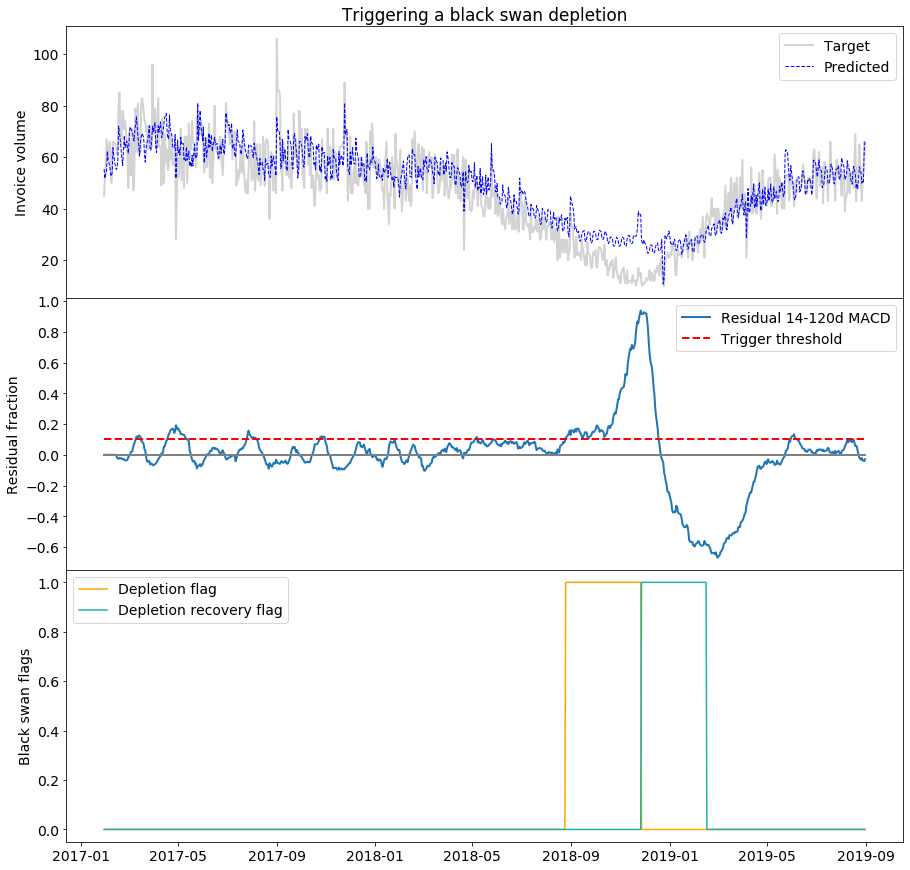

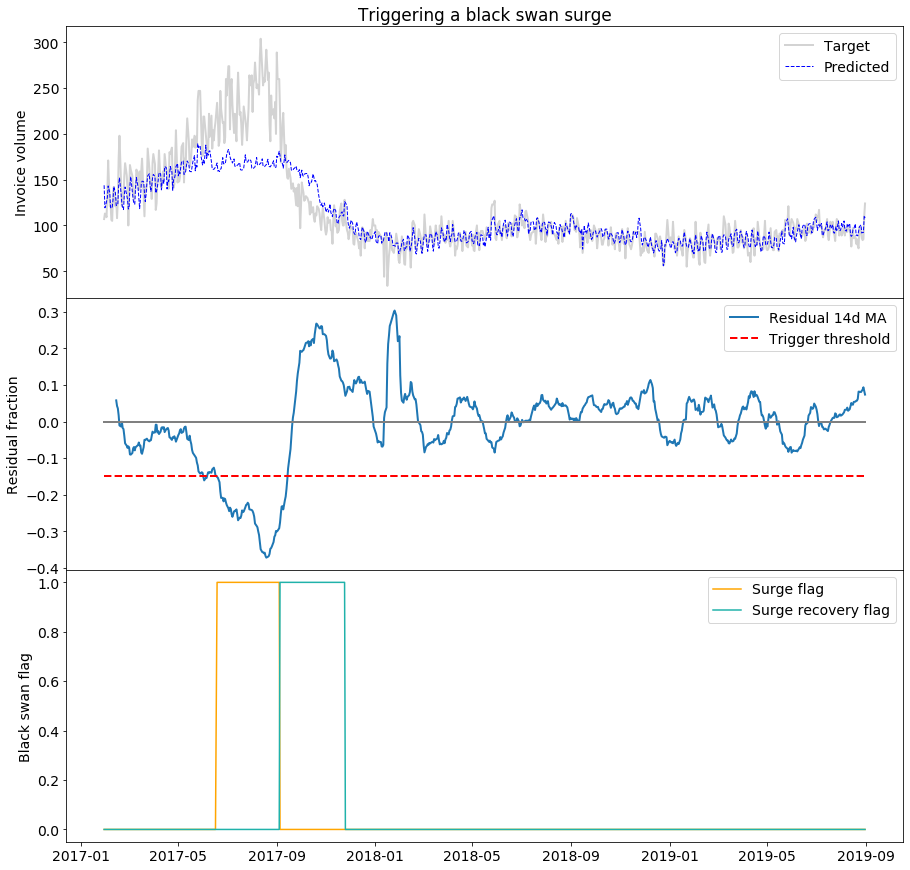

In [11]:
def plot_black_swan_flags(flag_df, mode, threshold):
    plt.rcParams['font.size'] = 14
    plt.rcParams['figure.figsize'] = 15, 15
    fig, ax = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
    ax[0].plot(flag_df['date'], flag_df['actual'], color='lightgrey', linewidth=2, label='Target')
    ax[0].plot(flag_df['date'], flag_df['predicted'], color='blue', linewidth=1, linestyle='--', label='Predicted')
    if mode == 'surge':
        ax[0].set_title('Triggering a black swan surge')
    elif mode == 'depletion':
        ax[0].set_title('Triggering a black swan depletion')
    ax[0].set_ylabel('Invoice volume')
    ax[0].legend()
    
    if mode == 'surge':
        ax[1].plot(flag_df['date'], flag_df['resid_ma_14d'], linewidth=2, label='Residual 14d MA')
    elif mode == 'depletion':
        ax[1].plot(flag_df['date'], flag_df['macd'], linewidth=2, label='Residual 14-120d MACD')
    ax[1].plot(flag_df['date'], [0] * len(flag_df), color='grey', linewidth=2)
    ax[1].plot(flag_df['date'], [threshold] * len(flag_df), color='red', linewidth=2, linestyle='--', label='Trigger threshold')
    ax[1].set_ylabel('Residual fraction')
    ax[1].legend()
    
    if mode == 'surge':
        ax[2].plot(flag_df['date'], flag_df['surge_flag'], color='orange', label='Surge flag')
        ax[2].plot(flag_df['date'], flag_df['surge_recovery_flag'], color='lightseagreen', label='Surge recovery flag')
        ax[2].set_ylabel('Black swan flag')
        ax[2].legend()
    else:
        ax[2].plot(flag_df['date'], flag_df['depletion_flag'], color='orange', label='Depletion flag')
        ax[2].plot(flag_df['date'], flag_df['depletion_recovery_flag'], color='lightseagreen', label='Depletion recovery flag')
        ax[2].set_ylabel('Black swan flags')
        ax[2].legend()
    
# Depletion
store = 'AZY 02'
flag_df = flagged_depletion.loc[flagged_depletion['store_code']==store]
plot_black_swan_flags(flag_df, mode='depletion', threshold=0.1)

# Surge
store = 'TNN 10'
flag_df = flagged_surge.loc[flagged_surge['store_code']==store]
plot_black_swan_flags(flag_df, mode='surge', threshold=-0.15)

## 3a. Retrain forecast model with synthetic depletion examples
---

Add black swan flags to the synthetic training samples. Set black swan flags to 0 for the real store samples. Concatenate flagged synthetic **depletion** profiles with the original training set to give a roughly 1:1 distribution of real and synthetic store samples. 

In [12]:
# Align dates/stores
flag_columns = syn_invoices_depletion_dict['y_train'].merge(
    flagged_depletion, 
    how='left',
    left_on=['date', 'store_id'],
    right_on=['date', 'store_code']
)[['depletion_flag', 'depletion_recovery_flag']]

# Add columns to synthetic training set
syn = syn_invoices_depletion_dict['X_train'].copy()
syn['depletion_flag'] = list(flag_columns['depletion_flag'])
syn['depletion_recovery_flag'] = list(flag_columns['depletion_recovery_flag'])
syn_target = syn_invoices_depletion_dict['y_train']['y_data'].copy()

# Add columns to real training set
real = real_invoices_dict['X_train'].copy()
real['depletion_flag'] = 0
real['depletion_recovery_flag'] = 0
real_target = real_invoices_dict['y_train']['y_data'].copy()

# Concatenate
train_set_depletion = pd.concat([syn, real], axis=0)
target_depletion = pd.concat([syn_target, real_target], axis=0)

Retrain the model with depletion flags included.

In [13]:
depletion_model = GradientBoostingRegressor(random_state=0, verbose=True).fit(
    train_set_depletion, 
    target_depletion
)

      Iter       Train Loss   Remaining Time 
         1         757.6684            1.76m
         2         642.7725            1.63m
         3         548.5308            1.59m
         4         471.4919            1.61m
         5         408.1916            1.58m
         6         356.5342            1.58m
         7         314.2556            1.56m
         8         279.4214            1.53m
         9         251.0399            1.53m
        10         227.6830            1.53m
        20         131.4015            1.42m
        30         112.3474            1.23m
        40         105.4092            1.14m
        50         101.4866            1.04m
        60          98.5595           51.77s
        70          96.4718           38.85s
        80          94.9295           25.80s
        90          93.7101           12.85s
       100          92.6270            0.00s


Plot depletion model feature importances.

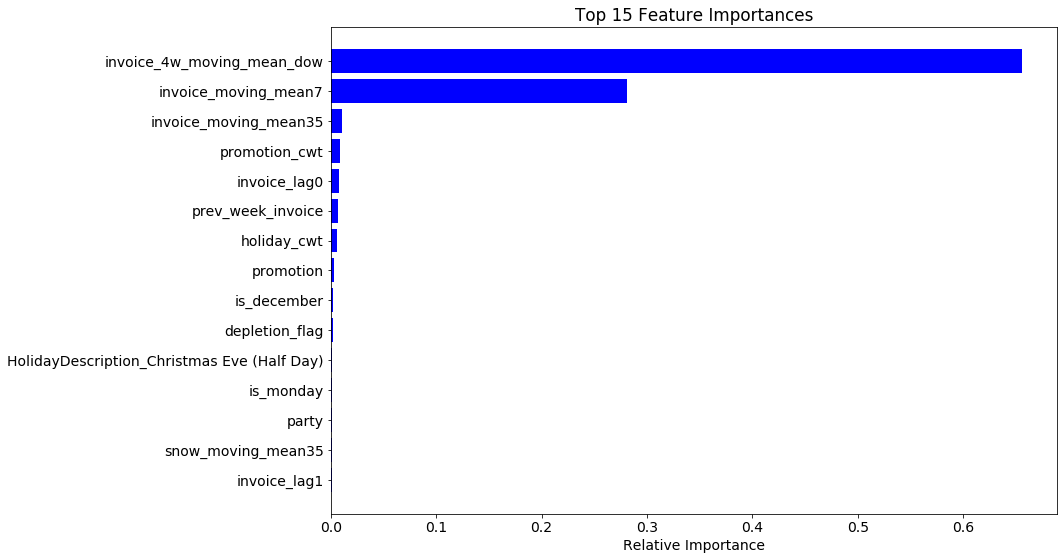

In [14]:
import numpy as np

top_n = 15
features = list(train_set_depletion.columns)
importances = depletion_model.feature_importances_
indices = np.argsort(importances)[-top_n:]
plt.figure(figsize=(15, 8))
plt.title(f'Top {top_n} Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()

## 3b. Retrain forecast model with synthetic surge examples
---

Add black swan flags to the synthetic training samples. Set black swan flags to 0 for the real store samples. Concatenate flagged synthetic **surge** profiles with the original training set to give a roughly 1:1 distribution of real and synthetic store samples. 

In [15]:
# Align dates/stores
flag_columns = syn_invoices_surge_dict['y_train'].merge(
    flagged_surge, 
    how='left',
    left_on=['date', 'store_id'],
    right_on=['date', 'store_code']
)[['surge_flag', 'surge_recovery_flag']]

# Add columns to synthetic training set
syn = syn_invoices_surge_dict['X_train'].copy()
syn['surge_flag'] = list(flag_columns['surge_flag'])
syn['surge_recovery_flag'] = list(flag_columns['surge_recovery_flag'])
syn_target = syn_invoices_surge_dict['y_train']['y_data'].copy()

# Add columns to real training set
real = real_invoices_dict['X_train'].copy()
real['surge_flag'] = 0
real['surge_recovery_flag'] = 0
real_target = real_invoices_dict['y_train']['y_data'].copy()

# Concatenate
train_set_surge = pd.concat([syn, real], axis=0)
target_surge = pd.concat([syn_target, real_target], axis=0)

Retrain the model with surge flags included.

In [16]:
surge_model = GradientBoostingRegressor(random_state=0, verbose=True).fit(
    train_set_surge, 
    target_surge
)

      Iter       Train Loss   Remaining Time 
         1        1202.2224            2.80m
         2        1023.6500            2.55m
         3         877.0281            2.46m
         4         757.3153            2.44m
         5         658.5437            2.34m
         6         578.1171            2.21m
         7         511.9718            2.14m
         8         456.9921            2.06m
         9         412.3526            2.03m
        10         375.6000            1.99m
        20         223.8030            1.68m
        30         192.2428            1.46m
        40         179.8629            1.28m
        50         172.6804            1.06m
        60         167.2251           52.25s
        70         163.6691           38.88s
        80         161.0191           25.86s
        90         158.5930           12.86s
       100         156.6957            0.00s


Plot surge model feature importances.

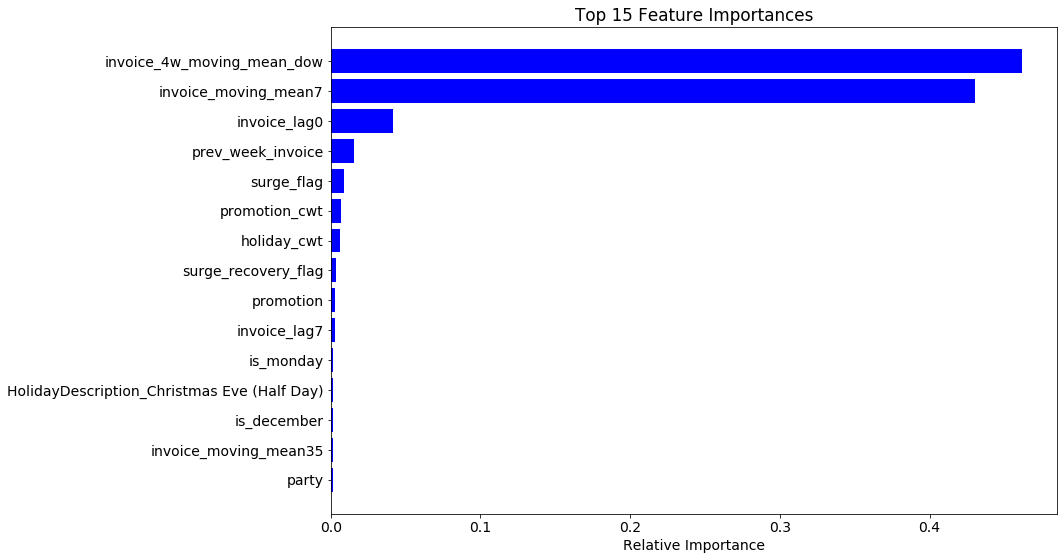

In [17]:
import numpy as np

top_n = 15
features = list(train_set_surge.columns)
importances = surge_model.feature_importances_
indices = np.argsort(importances)[-top_n:]
plt.figure(figsize=(15, 8))
plt.title(f'Top {top_n} Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()

## 4. Evaluate black swan models
---

Function to compare base model and black swan model forecasts.

In [18]:
def compare_model_forecasts(predictions_df, flag_df, mode):
    plt.rcParams['font.size'] = 14
    plt.rcParams['figure.figsize'] = 15, 15
    fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
    ax[0].plot(predictions_df['date'], predictions_df['y_data'], color='lightgrey', linewidth=2, label='Target')
    ax[0].plot(predictions_df['date'], predictions_df['predicted'], color='blue', linewidth=1, linestyle='--', label='Base prediction')
    ax[0].plot(predictions_df['date'], predictions_df['enhanced_prediction'], color='coral', linewidth=1, linestyle='-.', label='Enhanced prediction')
    ax[0].set_ylabel('Invoice volume')
    ax[0].legend()
    if mode == 'surge':
        ax[1].plot(flag_df['date'], flag_df['surge_flag'], color='orange', label='Surge flag')
        ax[1].plot(flag_df['date'], flag_df['surge_recovery_flag'], color='lightseagreen', label='Surge recovery flag')
    elif mode == 'depletion':
        ax[1].plot(flag_df['date'], flag_df['depletion_flag'], color='orange', label='Depletion flag')
        ax[1].plot(flag_df['date'], flag_df['depletion_recovery_flag'], color='lightseagreen', label='Depletion recovery flag')
    ax[1].set_ylabel('Black swan flags')
    ax[1].legend()

### Depletion test with out-of-sample synthetic invoices
Evaluate the performance of the depletion model on an out-of-sample synthetic store example (5 stores total reserved from training). 

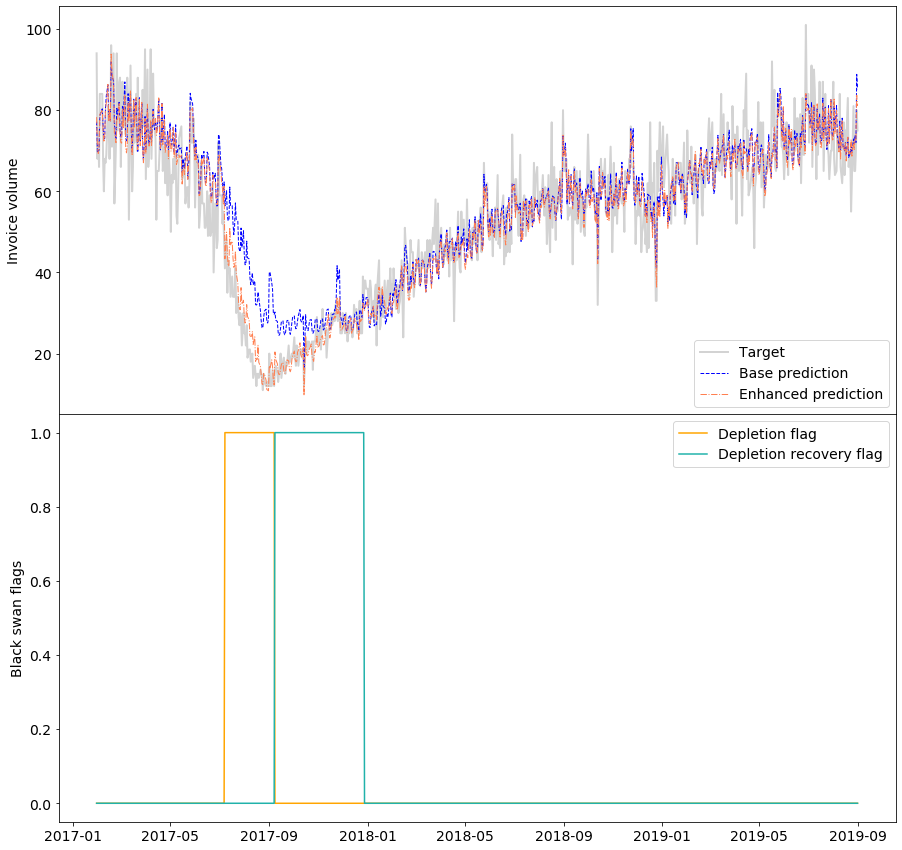

In [19]:
# Get base model predictions
base_model_predictions_syn_OOS = base_model.predict(syn_invoices_depletion_dict['X_test'])
syn_OOS_results = syn_invoices_depletion_dict['y_test'].copy()
syn_OOS_results['predicted'] = base_model_predictions_syn_OOS

# Create black swan flags for OOS stores
flagged_syn_OOS = flag_depletion(syn_OOS_results, macd_max_thresh=0.3, macd_break_thresh=0.1)

# Align dates/stores
flag_columns = syn_OOS_results.merge(
    flagged_syn_OOS, 
    how='left',
    left_on=['date', 'store_id'],
    right_on=['date', 'store_code']
)[['depletion_flag', 'depletion_recovery_flag']]

# Add columns to synthetic OOS set
syn_OOS_with_flags = syn_invoices_depletion_dict['X_test'].copy()
syn_OOS_with_flags['depletion_flag'] = list(flag_columns['depletion_flag'])
syn_OOS_with_flags['depletion_recovery_flag'] = list(flag_columns['depletion_recovery_flag'])

# Predict on flagged samples using depletion model
syn_OOS_results['enhanced_prediction'] = depletion_model.predict(syn_OOS_with_flags)

# Plot base model and enhanced model forecasts
store = 'CAS 39'

store_results_OOS = syn_OOS_results.loc[syn_OOS_results['store_id']==store]
store_flag_OOS = flagged_syn_OOS.loc[flagged_syn_OOS['store_code']==store]
compare_model_forecasts(store_results_OOS, store_flag_OOS, 'depletion')

### Depletion test with out-of-time real invoices
The systemic depletion of invoice volume in March of 2020 due to COVID offers a real-world example of a black swan event. This real signal was excluded from model training to test the ability of a synthetically augmented model to course correct following the sudden COVID-induced downturn. The plot below shows that the depletion in invoice volume meets the previously established triggering criteria in late March. Consequently, the subsequent forecasts generated with inclusion of the triggered event ("depletion_flag" = 1) show marked improvement compared to the base model prediction.

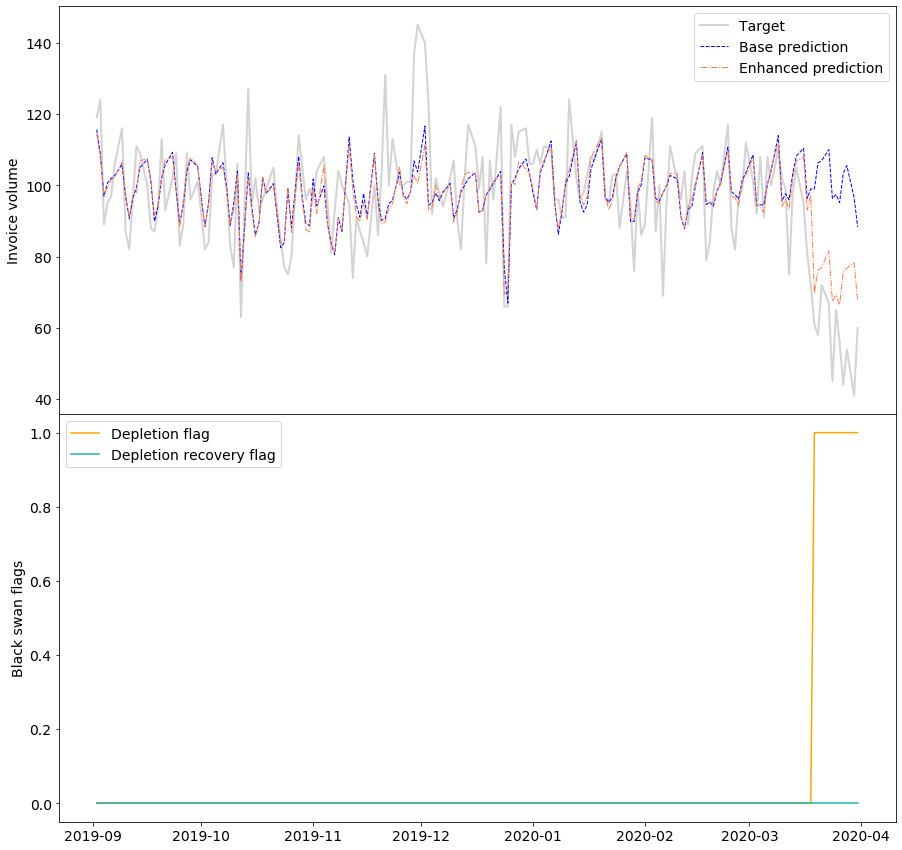

In [20]:
# Get base model predictions
base_model_predictions_OOT = base_model.predict(real_invoices_dict['X_test'])
real_OOT_results = real_invoices_dict['y_test'].copy()
real_OOT_results['predicted'] = base_model_predictions_OOT

# Create black swan flags for OOS stores
flagged_real_OOT = flag_depletion(real_OOT_results, macd_max_thresh=0.3, macd_break_thresh=0.1)

# Add flag columns to OOT test set
flag_columns = real_OOT_results.merge(
    flagged_real_OOT, 
    how='left',
    left_on=['date', 'store_id'],
    right_on=['date', 'store_code']
)[['depletion_flag', 'depletion_recovery_flag']]

# Add columns to real OOT set
real_OOT_with_flags = real_invoices_dict['X_test'].copy()
real_OOT_with_flags['depletion_flag'] = list(flag_columns['depletion_flag'])
real_OOT_with_flags['depletion_recovery_flag'] = list(flag_columns['depletion_recovery_flag'])

# Predict on flagged samples using depletion model
real_OOT_results['enhanced_prediction'] = depletion_model.predict(real_OOT_with_flags)

# Plot base model and enhanced model forecasts
store = 'CAS 06'

store_results_OOT = real_OOT_results.loc[real_OOT_results['store_id']==store]
store_flag_OOT = flagged_real_OOT.loc[flagged_real_OOT['store_code']==store]
compare_model_forecasts(store_results_OOT, store_flag_OOT, 'depletion')

To demonstrate the importance of the flag variables in the adaptive model, we can set a higher trigger threshold such that the sudden dip due to COVID is not flagged as a potential black swan. Below we observe that the forecasts generated in the absence of the black swan flag ("depletion_flag" = 0) overshoot actual invoice volume much like the base model.

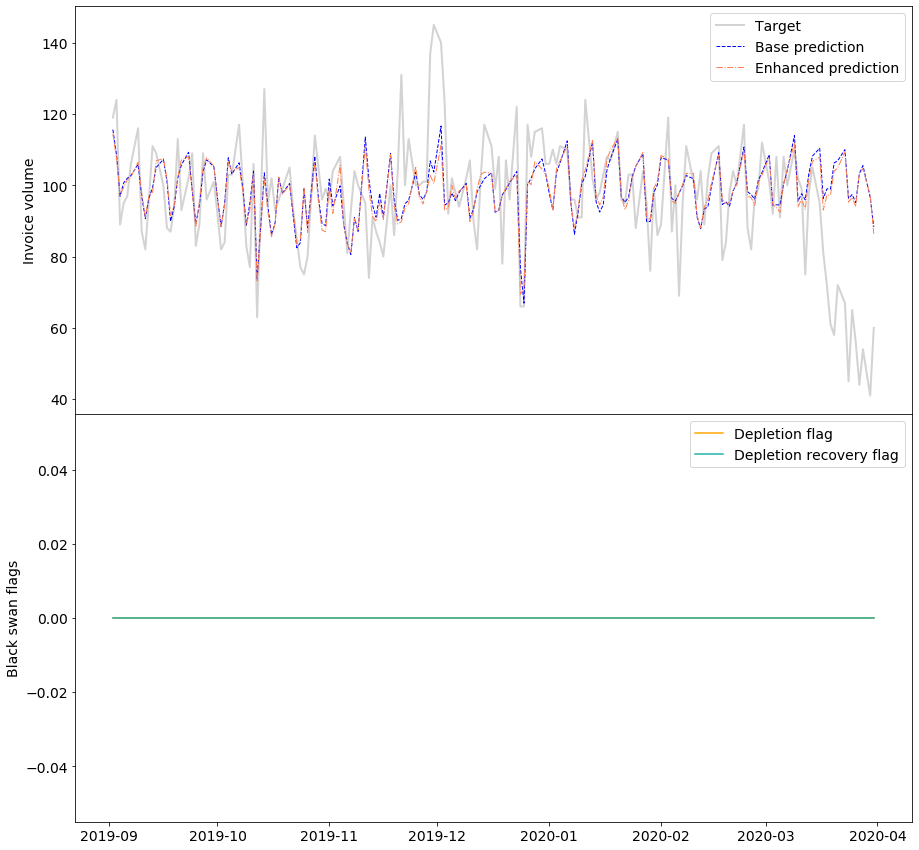

In [21]:
# Get base model predictions
base_model_predictions_OOT = base_model.predict(real_invoices_dict['X_test'])
real_OOT_results = real_invoices_dict['y_test'].copy()
real_OOT_results['predicted'] = base_model_predictions_OOT

# Create black swan flags for OOS stores -- set higher trigger threshold
flagged_real_OOT = flag_depletion(real_OOT_results, macd_max_thresh=1.0, macd_break_thresh=1.0)

# Add flag columns to OOT test set
flag_columns = real_OOT_results.merge(
    flagged_real_OOT, 
    how='left',
    left_on=['date', 'store_id'],
    right_on=['date', 'store_code']
)[['depletion_flag', 'depletion_recovery_flag']]

# Add columns to real OOT set
real_OOT_with_flags = real_invoices_dict['X_test'].copy()
real_OOT_with_flags['depletion_flag'] = list(flag_columns['depletion_flag'])
real_OOT_with_flags['depletion_recovery_flag'] = list(flag_columns['depletion_recovery_flag'])

# Predict on flagged samples using depletion model
real_OOT_results['enhanced_prediction'] = depletion_model.predict(real_OOT_with_flags)

# Plot base model and enhanced model forecasts
store = 'CAS 06'

store_results_OOT = real_OOT_results.loc[real_OOT_results['store_id']==store]
store_flag_OOT = flagged_real_OOT.loc[flagged_real_OOT['store_code']==store]
compare_model_forecasts(store_results_OOT, store_flag_OOT, 'depletion')

### Surge test with out-of-sample synthetic invoices
Evaluate the performance of the surge model on an out-of-sample synthetic store example (5 stores total reserved from training). 

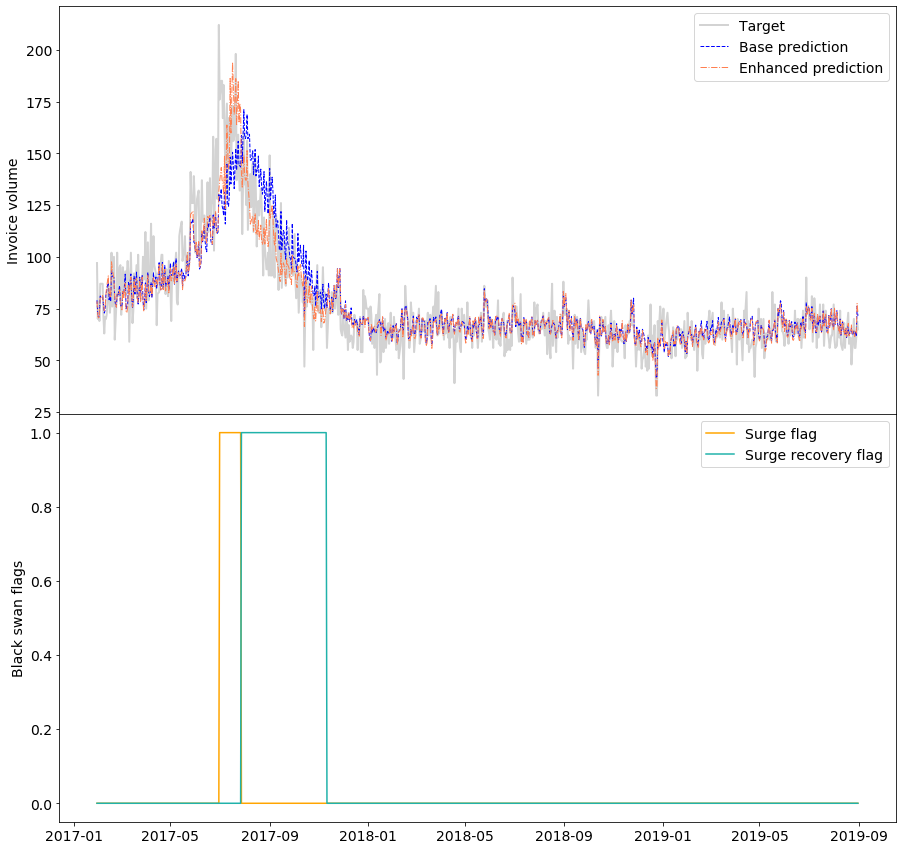

In [22]:
# Get base model predictions
base_model_predictions_syn_OOS = base_model.predict(syn_invoices_surge_dict['X_test'])
syn_OOS_results = syn_invoices_surge_dict['y_test'].copy()
syn_OOS_results['predicted'] = base_model_predictions_syn_OOS

# Create black swan flags for OOS stores
flagged_syn_OOS = flag_surge(syn_OOS_results, resid_max_thresh=-0.2, resid_break_thresh=-0.15)

# Align dates/stores
flag_columns = syn_OOS_results.merge(
    flagged_syn_OOS, 
    how='left',
    left_on=['date', 'store_id'],
    right_on=['date', 'store_code']
)[['surge_flag', 'surge_recovery_flag']]

# Add columns to synthetic OOS set
syn_OOS_with_flags = syn_invoices_surge_dict['X_test'].copy()
syn_OOS_with_flags['surge_flag'] = list(flag_columns['surge_flag'])
syn_OOS_with_flags['surge_recovery_flag'] = list(flag_columns['surge_recovery_flag'])

# Predict on flagged samples using depletion model
syn_OOS_results['enhanced_prediction'] = surge_model.predict(syn_OOS_with_flags)

# Plot base model and enhanced model forecasts
store = 'CAS 39'

store_results_OOS = syn_OOS_results.loc[syn_OOS_results['store_id']==store]
store_flag_OOS = flagged_syn_OOS.loc[flagged_syn_OOS['store_code']==store]
compare_model_forecasts(store_results_OOS, store_flag_OOS, 'surge')